# Peforming inference

This notebook details how to perform inference with the python scripts available. It is a jupyter notebook port of `do_inference.py`, with a little fluff.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pickle
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from hierarchial_model import UniformBHSM, plot_galaxy
import generate_sample

First, define the required arguments for the run:

In [3]:
args = pd.Series(dict(
    ngals=5,
    ntune=500,
    ndraws=1000,
    arms_df='lib/merged_arms.pickle',
    output='',
))

Then, generate the sample of galaxies to work on using the helper function available in `generate_sample.py`

In [4]:
galaxies = generate_sample.generate_sample(
    n_gals=args.ngals,
    seed=0,
    arms_df=args.arms_df
)

Let's plot an example of what one of the galaxy arms looks like

In [5]:
example_idx = galaxies.str.len().idxmax()

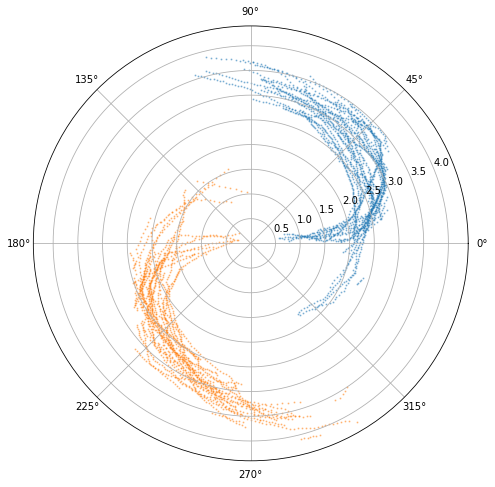

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
plot_galaxy(example_idx, galaxies=galaxies, many_colored=True, plot_fit=False)

Define our output file name

In [7]:
if args.output == '':
    args.output = 'n{}d{}t{}.pickle'.format(
        len(galaxies),
        args.ndraws,
        args.ntune,
    )

Initialize the model using the custom BHSM class

In [8]:
bhsm = UniformBHSM(galaxies)

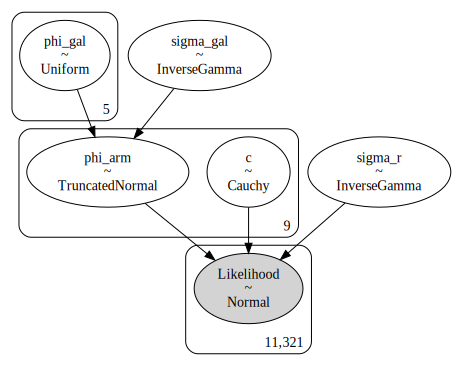

In [9]:
pm.model_to_graphviz(bhsm.model)

Perform inference using the No-U-Turn Sampler (NUTS)

In [10]:
trace = bhsm.do_inference(
    draws=args.ndraws,
    tune=args.ntune,
)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


phi_gal_interval__   -6.930000e+00
sigma_gal_log__      -1.230000e+00
c                    -3.103000e+01
sigma_r_log__        -8.000000e-01
phi_arm_interval__    5.270000e+00
Likelihood           -1.506278e+08
Name: Log-probability of test_point, dtype: float64


Convergence achieved at 40000
Interrupted at 39,999 [19%]: Average Loss = 1.3647e+39
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi_arm, sigma_r, c, sigma_gal, phi_gal]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 110 seconds.
The number of effective samples is smaller than 25% for some parameters.


If we have any diverging chains, something has gone wrong:

In [11]:
divergent = trace['diverging']

print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


What does the resulting fit look like?

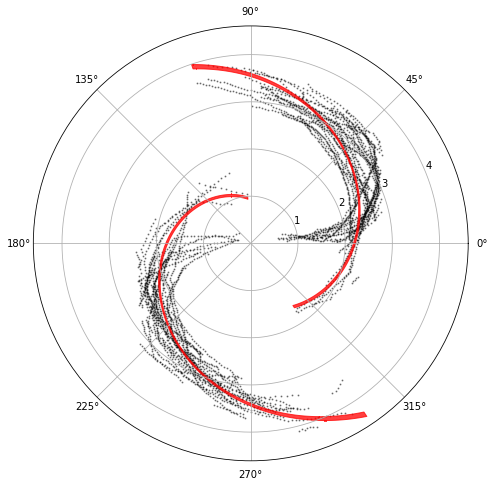

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
plot_galaxy(example_idx, bhsm=bhsm, trace=trace)

Saving the model is straightforward:

In [13]:
bhsm.save(args.output, trace)

As is loading it back in for analysis:

In [14]:
result = UniformBHSM.load(args.output)

In [15]:
result['bhsm'].model